In [1]:
import nest_asyncio
import asyncio

# Apply the patch to allow nested event loops
nest_asyncio.apply()
from dotenv import load_dotenv
from minference.threads.inference import InferenceOrchestrator, RequestLimits
from minference.threads.models import ChatMessage, ChatThread, LLMConfig, CallableTool, LLMClient,ResponseFormat, SystemPrompt, StructuredTool, Usage,GeneratedJsonObject
from typing import Literal, List
from minference.ecs.caregistry import CallableRegistry
import time
from minference.clients.utils import msg_dict_to_oai, msg_dict_to_anthropic, parse_json_string
from minference.ecs.entity import EntityRegistry
import os
import logging
import json

In [2]:
load_dotenv()
EntityRegistry()
CallableRegistry()

In [3]:
oai_request_limits = RequestLimits(max_requests_per_minute=10000, max_tokens_per_minute=200000000)
lite_llm_request_limits = RequestLimits(max_requests_per_minute=500, max_tokens_per_minute=200000)
anthropic_request_limits = RequestLimits(max_requests_per_minute=500, max_tokens_per_minute=80000)
vllm_request_limits = RequestLimits(max_requests_per_minute=500000, max_tokens_per_minute=200000000)

In [4]:
lite_llm_model = "qwen2.5-7b-instruct-mlx"
anthropic_model = "claude-3-5-sonnet-latest"
vllm_model = "Qwen/Qwen2.5-7B-Instruct"
openai_model = "gpt-4o-mini"

In [5]:
orchestrator = InferenceOrchestrator(oai_request_limits=oai_request_limits, litellm_request_limits=lite_llm_request_limits, anthropic_request_limits=anthropic_request_limits, vllm_request_limits=vllm_request_limits)
EntityRegistry.set_inference_orchestrator(orchestrator)
EntityRegistry.set_tracing_enabled(False)

In [6]:
#load json from all_monsters.json
try:
    all_monsters = json.load(open(r"/Users/tommasofurlanello/Documents/Dev/MarketInference/examples/all_monsters.json"))
except:
    import requests
    import os

    def download_bestiary_data():
        # Define URLs for GitHub raw content
        INDEX_URL = "https://raw.githubusercontent.com/5etools-mirror-3/5etools-src/main/data/bestiary/index.json"
        BASE_URL = "https://raw.githubusercontent.com/5etools-mirror-3/5etools-src/main/data/bestiary/"
        
        # Create directory for downloaded files
        os.makedirs("bestiary_files", exist_ok=True)
        
        # Check if index file exists locally
        if os.path.exists("bestiary_files/index.json"):
            print("Loading bestiary index from local file...")
            with open("bestiary_files/index.json", "r", encoding="utf-8") as f:
                index_data = json.load(f)
            print(f"Index loaded successfully. Found {len(index_data)} entries.")
        else:
            print("Downloading bestiary index...")
            try:
                # Get the index file
                response = requests.get(INDEX_URL)
                response.raise_for_status()
                index_data = response.json()
                
                # Save the index file
                with open("bestiary_files/index.json", "w", encoding="utf-8") as f:
                    json.dump(index_data, f, indent=2)
                    
                print(f"Index downloaded successfully. Found {len(index_data)} entries.")
            except Exception as e:
                print(f"Error downloading index: {e}")
                return None
        
        # Filter for only bestiary files
        bestiary_files = {key: filename for key, filename in index_data.items() 
                        if filename.startswith("bestiary-")}
        
        print(f"Found {len(bestiary_files)} bestiary files to process.")
        
        # Download each bestiary file (if it doesn't exist locally)
        all_monsters = []
        failed_files = []
        
        for key, filename in bestiary_files.items():
            local_path = f"bestiary_files/{filename}"
            
            # Check if file already exists locally
            if os.path.exists(local_path):
                print(f"Loading {filename} from local file...")
                try:
                    with open(local_path, "r", encoding="utf-8") as f:
                        file_data = json.load(f)
                except Exception as e:
                    print(f"  Error loading local file {filename}: {e}")
                    failed_files.append(filename)
                    continue
            else:
                file_url = BASE_URL + filename
                print(f"Downloading {filename}...")
                
                try:
                    response = requests.get(file_url)
                    response.raise_for_status()
                    file_data = response.json()
                    
                    # Save the file locally
                    with open(local_path, "w", encoding="utf-8") as f:
                        json.dump(file_data, f, indent=2)
                except Exception as e:
                    print(f"  Error downloading {filename}: {e}")
                    failed_files.append(filename)
                    continue
            
            # Extract monster data if present
            if "monster" in file_data:
                monsters_in_file = file_data["monster"]
                all_monsters.extend(monsters_in_file)
                print(f"  Added {len(monsters_in_file)} monsters from {filename}")
            else:
                print(f"  No monsters found in {filename}")
        
        # Create combined monster dictionary
        combined_data = {"monster": all_monsters}
        
        # Save combined data
        with open("all_monsters.json", "w", encoding="utf-8") as f:
            json.dump(combined_data, f, indent=2)
        
        print(f"\nProcessing complete!")
        print(f"Successfully processed {len(bestiary_files) - len(failed_files)} files")
        print(f"Combined {len(all_monsters)} monsters into 'all_monsters.json'")
        
        if failed_files:
            print(f"Failed to process {len(failed_files)} files: {', '.join(failed_files)}")
        
        return combined_data
    all_monsters = download_bestiary_data()



In [7]:
assert all_monsters is not None
monster_manual = {}
for monster in all_monsters['monster']:
    #monster is a dict we want ot dump it to json string
    monster_manual[monster["name"]] = json.dumps(monster)


In [8]:
number_of_monsters = len(monster_manual.keys())
print(number_of_monsters)

4194


In [9]:
simpler_monster_schema={
  "type": "object",
  "title": "Monster",
  "description": "Simplified D&D 5e monster stats with focus on numerical values",
  "properties": {
    "name": {
      "type": "string",
      "description": "The monster's name"
    },
    "source": {
      "type": ["string", "null"],
      "description": "Source book"
    },
    "size": {
      "type": ["string", "null"],
      "enum": ["T", "S", "M", "L", "H", "G"],
      "description": "Size code"
    },
    "type": {
      "type": ["string", "null"],
      "description": "Creature type"
    },
    "ac": {
      "type": ["integer", "null"],
      "description": "Armor class"
    },
    "hp": {
      "type": ["integer", "null"],
      "description": "Hit points"
    },
    "hd_count": {
      "type": ["integer", "null"],
      "description": "Hit dice count"
    },
    "hd_size": {
      "type": ["integer", "null"],
      "description": "Hit dice size"
    },
    "hd_bonus": {
      "type": ["integer", "null"],
      "description": "Hit dice modifier"
    },
    "strength": {
      "type": ["integer", "null"],
      "description": "Strength"
    },
    "dexterity": {
      "type": ["integer", "null"],
      "description": "Dexterity"
    },
    "constitution": {
      "type": ["integer", "null"],
      "description": "Constitution"
    },
    "intelligence": {
      "type": ["integer", "null"],
      "description": "Intelligence"
    },
    "wisdom": {
      "type": ["integer", "null"],
      "description": "Wisdom"
    },
    "charisma": {
      "type": ["integer", "null"],
      "description": "Charisma"
    },
    "speed_walk": {
      "type": ["integer", "null"],
      "description": "Walking speed"
    },
    "speed_fly": {
      "type": ["integer", "null"],
      "description": "Flying speed"
    },
    "speed_swim": {
      "type": ["integer", "null"],
      "description": "Swimming speed"
    },
    "speed_climb": {
      "type": ["integer", "null"],
      "description": "Climbing speed"
    },
    "speed_burrow": {
      "type": ["integer", "null"],
      "description": "Burrowing speed"
    },
    "darkvision": {
      "type": ["integer", "null"],
      "description": "Darkvision range"
    },
    "blindsight": {
      "type": ["integer", "null"],
      "description": "Blindsight range"
    },
    "tremorsense": {
      "type": ["integer", "null"],
      "description": "Tremorsense range"
    },
    "truesight": {
      "type": ["integer", "null"],
      "description": "Truesight range"
    },
    "passive_perception": {
      "type": ["integer", "null"],
      "description": "Passive perception"
    },
    "cr": {
      "type": ["number", "string", "null"],
      "description": "Challenge rating"
    },
    "xp": {
      "type": ["integer", "null"],
      "description": "XP value"
    },
    "prof_bonus": {
      "type": ["integer", "null"],
      "description": "Proficiency bonus"
    },
    "multiattack_count": {
      "type": ["integer", "null"],
      "description": "Number of attacks in multiattack"
    },
    "attack1_bonus": {
      "type": ["integer", "null"],
      "description": "Attack 1 to-hit bonus"
    },
    "attack1_reach": {
      "type": ["integer", "null"],
      "description": "Attack 1 reach"
    },
    "attack1_range": {
      "type": ["integer", "null"],
      "description": "Attack 1 range"
    },
    "attack1_dice_count": {
      "type": ["integer", "null"],
      "description": "Attack 1 damage dice count"
    },
    "attack1_dice_size": {
      "type": ["integer", "null"],
      "description": "Attack 1 damage dice size"
    },
    "attack1_damage_bonus": {
      "type": ["integer", "null"],
      "description": "Attack 1 damage bonus"
    },
    "attack2_bonus": {
      "type": ["integer", "null"],
      "description": "Attack 2 to-hit bonus"
    },
    "attack2_reach": {
      "type": ["integer", "null"],
      "description": "Attack 2 reach"
    },
    "attack2_range": {
      "type": ["integer", "null"],
      "description": "Attack 2 range"
    },
    "attack2_dice_count": {
      "type": ["integer", "null"],
      "description": "Attack 2 damage dice count"
    },
    "attack2_dice_size": {
      "type": ["integer", "null"],
      "description": "Attack 2 damage dice size"
    },
    "attack2_damage_bonus": {
      "type": ["integer", "null"],
      "description": "Attack 2 damage bonus"
    },
    "save_dc1": {
      "type": ["integer", "null"],
      "description": "Save DC 1"
    },
    "save_dc2": {
      "type": ["integer", "null"],
      "description": "Save DC 2"
    },
    "legendary_actions_count": {
      "type": ["integer", "null"],
      "description": "Number of legendary actions per round"
    },
    "spellcasting_level": {
      "type": ["integer", "null"],
      "description": "Spellcasting level"
    }
  },
  "required": [
    "name", "source", "size", "type", "ac", "hp", "hd_count", "hd_size", "hd_bonus",
    "str", "dex", "con", "int", "wis", "cha", 
    "speed_walk", "speed_fly", "speed_swim", "speed_climb", "speed_burrow",
    "darkvision", "blindsight", "tremorsense", "truesight", "passive_perception",
    "cr", "xp", "prof_bonus", "multiattack_count",
    "attack1_bonus", "attack1_reach", "attack1_range", "attack1_dice_count", 
    "attack1_dice_size", "attack1_damage_bonus",
    "attack2_bonus", "attack2_reach", "attack2_range", "attack2_dice_count", 
    "attack2_dice_size", "attack2_damage_bonus",
    "save_dc1", "save_dc2", "legendary_actions_count", "spellcasting_level"
  ],
  "additionalProperties": False
}


In [10]:
monster_extractor = StructuredTool(name="monster_extractor",json_schema=simpler_monster_schema, post_validate_schema=False)

system_prompt = SystemPrompt(content="You are a epidemiologist expert that is studying monsters in an alternative universe that can extract information from a text and convert it into a structured output. You will be given a text and you will need to extract the information and convert it into a structured output. You will be given a text and you will need to extract the information and convert it into a structured output.", name= "monster_extractor")


In [11]:
llm_config_vllm_modal = LLMConfig(client=LLMClient.vllm, model=vllm_model, response_format=ResponseFormat.tool,max_tokens=4000)

llm_config_litellm_lmstudio = LLMConfig(client=LLMClient.litellm, model=lite_llm_model, response_format=ResponseFormat.tool,max_tokens=4000)
llm_config_oai =LLMConfig(client=LLMClient.openai, model="gpt-4o-mini", response_format=ResponseFormat.tool,max_tokens=4000)
llm_config_anthropic = LLMConfig(client=LLMClient.anthropic, model=anthropic_model, response_format=ResponseFormat.tool,max_tokens=4000)


In [12]:
oai_thread =  ChatThread(
    system_prompt=system_prompt,
    new_message="",
    llm_config=llm_config_oai,
    forced_output=monster_extractor,
    use_schema_instruction=True
)

vllm_thread = ChatThread(
    system_prompt=system_prompt,
    new_message="",
    llm_config=llm_config_vllm_modal,
    forced_output=monster_extractor,
    use_schema_instruction=True
)

lm_studio_thread = ChatThread(
    system_prompt=system_prompt,
    new_message="",
    llm_config=llm_config_litellm_lmstudio,
    forced_output=monster_extractor,
    use_schema_instruction=True
)

anthropic_thread = ChatThread(
    system_prompt=system_prompt,
    new_message="",
    llm_config=llm_config_anthropic,
    forced_output=monster_extractor,
    use_schema_instruction=True
)

In [13]:
oai_threads = []
i = 0
for monster_name, monster_data in monster_manual.items():
    if i >2100:
        break
    base_thread  = EntityRegistry.get(oai_thread.id)
    assert base_thread is not None
    base_thread.fork(force=True,**{"new_message":f"Please study in detail the monster {monster_data}"})
    oai_threads.append(base_thread.id)
    i += 1

In [14]:
vllm_threads = []
j = 0
for monster_name, monster_data in monster_manual.items():
    if j> 2100 and j < 4160:
      base_thread  = EntityRegistry.get(vllm_thread.id)
      assert base_thread is not None
      base_thread.fork(force=True,**{"new_message":f"Please study in detail the monster {monster_data}"})
      vllm_threads.append(base_thread.id)
    j+=1

In [15]:
anthropic_threads = []
k = 0
for monster_name, monster_data in monster_manual.items():
    if k> 4160 and k < 4184:
      base_thread  = EntityRegistry.get(anthropic_thread.id)
      assert base_thread is not None
      base_thread.fork(force=True,**{"new_message":f"Please study in detail the monster {monster_data}"})
      anthropic_threads.append(base_thread.id)
    k+=1


In [16]:
lm_studio_threads = []
l = 0
for monster_name, monster_data in monster_manual.items():
    if l> 4184 and l < 4500:
      base_thread  = EntityRegistry.get(lm_studio_thread.id)
      assert base_thread is not None
      base_thread.fork(force=True,**{"new_message":f"Please study in detail the monster {monster_data}"})
      lm_studio_threads.append(base_thread.id)
    l+=1


In [17]:
oai_chats = EntityRegistry.get_many(oai_threads)
vllm_chats = EntityRegistry.get_many(vllm_threads)
anthropic_chats = EntityRegistry.get_many(anthropic_threads)
lm_studio_chats = EntityRegistry.get_many(lm_studio_threads)

all_chats = oai_chats+vllm_chats+anthropic_chats+lm_studio_chats


In [ ]:
import time
import asyncio
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

# Get the number of CPU cores
num_cores = multiprocessing.cpu_count()

async def run_all_providers():
    # Create tasks for each provider
    tasks = [
        orchestrator.run_parallel_ai_completion(oai_chats),
        orchestrator.run_parallel_ai_completion(vllm_chats),
        orchestrator.run_parallel_ai_completion(anthropic_chats),
        orchestrator.run_parallel_ai_completion(lm_studio_chats)
    ]
    
    # Wait for all tasks to complete
    all_outputs = await asyncio.gather(*tasks)
    
    # Flatten the list of outputs
    return [output for provider_outputs in all_outputs for output in provider_outputs]

start_time = time.time()
processed_outputs = asyncio.run(run_all_providers())
end_time = time.time()

INFO:EntityRegistry:Preparing vllm requests for 2059 chat threads
INFO:EntityRegistry:Wrote 2059 requests to /Users/tommasofurlanello/Documents/Dev/MarketInference/outputs/inference_cache/vllm_requests_cc3cd571-623b-476d-b587-1eba84622d6d_2025-03-03_18-01-18.jsonl
INFO:EntityRegistry:Preparing anthropic requests for 23 chat threads
INFO:EntityRegistry:Wrote 23 requests to /Users/tommasofurlanello/Documents/Dev/MarketInference/outputs/inference_cache/anthropic_requests_a0b4ead7-1faa-4de8-afd6-8753a497834b_2025-03-03_18-01-18.jsonl
INFO:EntityRegistry:Preparing litellm requests for 9 chat threads
INFO:EntityRegistry:Getting OpenAI request for ChatThread(ac3f7fe3-9936-4415-bef9-fd45ee47d78a) with response format ResponseFormat.tool
INFO:EntityRegistry:Validated OpenAI request for ChatThread(ac3f7fe3-9936-4415-bef9-fd45ee47d78a) with response format ResponseFormat.tool
INFO:EntityRegistry:Getting OpenAI request for ChatThread(7b121ff6-b198-4d7e-8d2a-594946728b58) with response format Respo

In [19]:
print(f"Time taken: {end_time - start_time} seconds for a total of {len(processed_outputs)} threads with an average of {(end_time - start_time)/len(processed_outputs)}  seconds per thread with a total of cpu cores {num_cores}")


Time taken: 136.3776330947876 seconds for a total of 4192 threads with an average of 0.032532832322229865  seconds per thread with a total of cpu cores 16


In [23]:
from typing import Optional, Union, Literal
from pydantic import BaseModel, Field


class Monster(BaseModel):
    """Simplified D&D 5e monster stats with focus on numerical values"""
    
    name: str = Field(description="The monster's name")
    source: Optional[str] = Field(None, description="Source book")
    size: Optional[Literal["T", "S", "M", "L", "H", "G"]] = Field(None, description="Size code")
    type: Optional[str] = Field(None, description="Creature type")
    ac: Optional[int] = Field(None, description="Armor class")
    hp: Optional[int] = Field(None, description="Hit points")
    hd_count: Optional[int] = Field(None, description="Hit dice count")
    hd_size: Optional[int] = Field(None, description="Hit dice size")
    hd_bonus: Optional[int] = Field(None, description="Hit dice modifier")
    strength: Optional[int] = Field(None, description="Strength")
    dexterity: Optional[int] = Field(None, description="Dexterity")
    constitution: Optional[int] = Field(None, description="Constitution")
    intelligence: Optional[int] = Field(None, description="Intelligence")
    wisdom: Optional[int] = Field(None, description="Wisdom")
    charisma: Optional[int] = Field(None, description="Charisma")
    speed_walk: Optional[int] = Field(None, description="Walking speed")
    speed_fly: Optional[int] = Field(None, description="Flying speed")
    speed_swim: Optional[int] = Field(None, description="Swimming speed")
    speed_climb: Optional[int] = Field(None, description="Climbing speed")
    speed_burrow: Optional[int] = Field(None, description="Burrowing speed")
    darkvision: Optional[int] = Field(None, description="Darkvision range")
    blindsight: Optional[int] = Field(None, description="Blindsight range")
    tremorsense: Optional[int] = Field(None, description="Tremorsense range")
    truesight: Optional[int] = Field(None, description="Truesight range")
    passive_perception: Optional[int] = Field(None, description="Passive perception")
    cr: Optional[Union[float, str]] = Field(None, description="Challenge rating")
    xp: Optional[int] = Field(None, description="XP value")
    prof_bonus: Optional[int] = Field(None, description="Proficiency bonus")
    multiattack_count: Optional[int] = Field(None, description="Number of attacks in multiattack")
    attack1_bonus: Optional[int] = Field(None, description="Attack 1 to-hit bonus")
    attack1_reach: Optional[int] = Field(None, description="Attack 1 reach")
    attack1_range: Optional[int] = Field(None, description="Attack 1 range")
    attack1_dice_count: Optional[int] = Field(None, description="Attack 1 damage dice count")
    attack1_dice_size: Optional[int] = Field(None, description="Attack 1 damage dice size")
    attack1_damage_bonus: Optional[int] = Field(None, description="Attack 1 damage bonus")
    attack2_bonus: Optional[int] = Field(None, description="Attack 2 to-hit bonus")
    attack2_reach: Optional[int] = Field(None, description="Attack 2 reach")
    attack2_range: Optional[int] = Field(None, description="Attack 2 range")
    attack2_dice_count: Optional[int] = Field(None, description="Attack 2 damage dice count")
    attack2_dice_size: Optional[int] = Field(None, description="Attack 2 damage dice size")
    attack2_damage_bonus: Optional[int] = Field(None, description="Attack 2 damage bonus")
    save_dc1: Optional[int] = Field(None, description="Save DC 1")
    save_dc2: Optional[int] = Field(None, description="Save DC 2")
    legendary_actions_count: Optional[int] = Field(None, description="Number of legendary actions per round")
    spellcasting_level: Optional[int] = Field(None, description="Spellcasting level")
    
    class Config:
        extra = "forbid"  # Corresponds to additionalProperties: False in the schem

In [21]:
all_objects_dicts = EntityRegistry.list_by_type(GeneratedJsonObject)
print(len(all_objects_dicts))

4192


In [22]:
all_objects = [o.object for o in all_objects_dicts if o.object is not None]
print(len(all_objects))

4192


In [ ]:
validated_objects : List[Monster] = []
errors = 0
for o in all_objects:
    try:
        validated_object = Monster.model_validate(o)
        validated_objects.append(validated_object)
    except Exception as e:
        errors+=1
print(f"Number of errors: {errors}")


Number of errors: 281


In [41]:
import polars as pl
dumped_objects = [obj.model_dump() for obj in validated_objects]
monster_df = pl.DataFrame(dumped_objects)

In [42]:
monster_df

name,source,size,type,ac,hp,hd_count,hd_size,hd_bonus,strength,dexterity,constitution,intelligence,wisdom,charisma,speed_walk,speed_fly,speed_swim,speed_climb,speed_burrow,darkvision,blindsight,tremorsense,truesight,passive_perception,cr,xp,prof_bonus,multiattack_count,attack1_bonus,attack1_reach,attack1_range,attack1_dice_count,attack1_dice_size,attack1_damage_bonus,attack2_bonus,attack2_reach,attack2_range,attack2_dice_count,attack2_dice_size,attack2_damage_bonus,save_dc1,save_dc2,legendary_actions_count,spellcasting_level
str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Seahorse""","""XMM""","""T""","""beast""",12,1,1,4,-1,1,12,8,1,10,2,5,0,20,0,0,0,0,0,0,12,"""0""",0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""Scout Captain""","""XMM""","""M""","""humanoid""",15,66,12,8,12,11,16,12,14,15,11,30,null,null,30,null,null,null,null,null,16,"""3""",700,2,2,5,5,null,1,6,3,5,null,150,1,8,3,null,null,null,null
"""Swarm of Crawling Claws""","""XMM""","""M""","""undead""",12,49,11,8,0,14,14,11,5,10,4,30,0,0,30,0,0,30,0,0,10,"""3""",700,2,1,4,5,0,4,8,2,null,null,null,null,null,null,null,null,0,0
"""Sphinx of Wonder""","""XMM""","""T""","""celestial""",13,24,7,4,7,6,17,13,15,12,11,20,40,0,0,0,60,0,0,0,11,"""1""",200,2,0,5,5,0,1,4,3,null,null,null,null,null,null,null,null,0,0
"""Swarm of Stirges""","""XMM""","""M""","""monstrosity""",14,36,8,8,0,4,16,11,2,8,6,10,40,0,0,0,60,0,0,0,9,"""2""",450,2,1,5,5,0,2,10,3,0,0,0,0,0,0,13,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Pirate""","""XMM""","""M""","""humanoid""",14,33,6,8,6,10,16,12,8,12,14,30,null,null,null,null,null,null,null,null,11,"""1""",400,2,2,5,5,20,1,4,3,null,null,null,null,null,null,12,null,null,null
"""Pirate Admiral""","""XMM""","""M""","""humanoid""",20,182,28,8,56,14,22,14,12,14,19,30,null,null,null,null,null,null,null,null,16,"""12""",null,3,3,10,5,null,3,6,6,10,null,30,4,10,6,16,null,null,null
"""Salamander Fire Snake""","""XMM""","""M""","""elemental""",14,27,null,null,null,12,14,11,7,10,8,30,null,null,30,null,60,null,null,null,10,"""1""",null,null,null,4,5,null,1,8,2,null,null,null,null,null,null,null,null,null,null


In [36]:
print(monster_df.schema)

Schema({'name': String, 'source': String, 'size': String, 'type': String, 'ac': Int64, 'hp': Int64, 'hd_count': Int64, 'hd_size': Int64, 'hd_bonus': Int64, 'strength': Int64, 'dexterity': Int64, 'constitution': Int64, 'intelligence': Int64, 'wisdom': Int64, 'charisma': Int64, 'speed_walk': Int64, 'speed_fly': Int64, 'speed_swim': Int64, 'speed_climb': Int64, 'speed_burrow': Int64, 'darkvision': Int64, 'blindsight': Int64, 'tremorsense': Int64, 'truesight': Int64, 'passive_perception': Int64, 'cr': String, 'xp': Int64, 'prof_bonus': Int64, 'multiattack_count': Int64, 'attack1_bonus': Int64, 'attack1_reach': Int64, 'attack1_range': Int64, 'attack1_dice_count': Int64, 'attack1_dice_size': Int64, 'attack1_damage_bonus': Int64, 'attack2_bonus': Int64, 'attack2_reach': Int64, 'attack2_range': Int64, 'attack2_dice_count': Int64, 'attack2_dice_size': Int64, 'attack2_damage_bonus': Int64, 'save_dc1': Int64, 'save_dc2': Int64, 'legendary_actions_count': Int64, 'spellcasting_level': Int64})


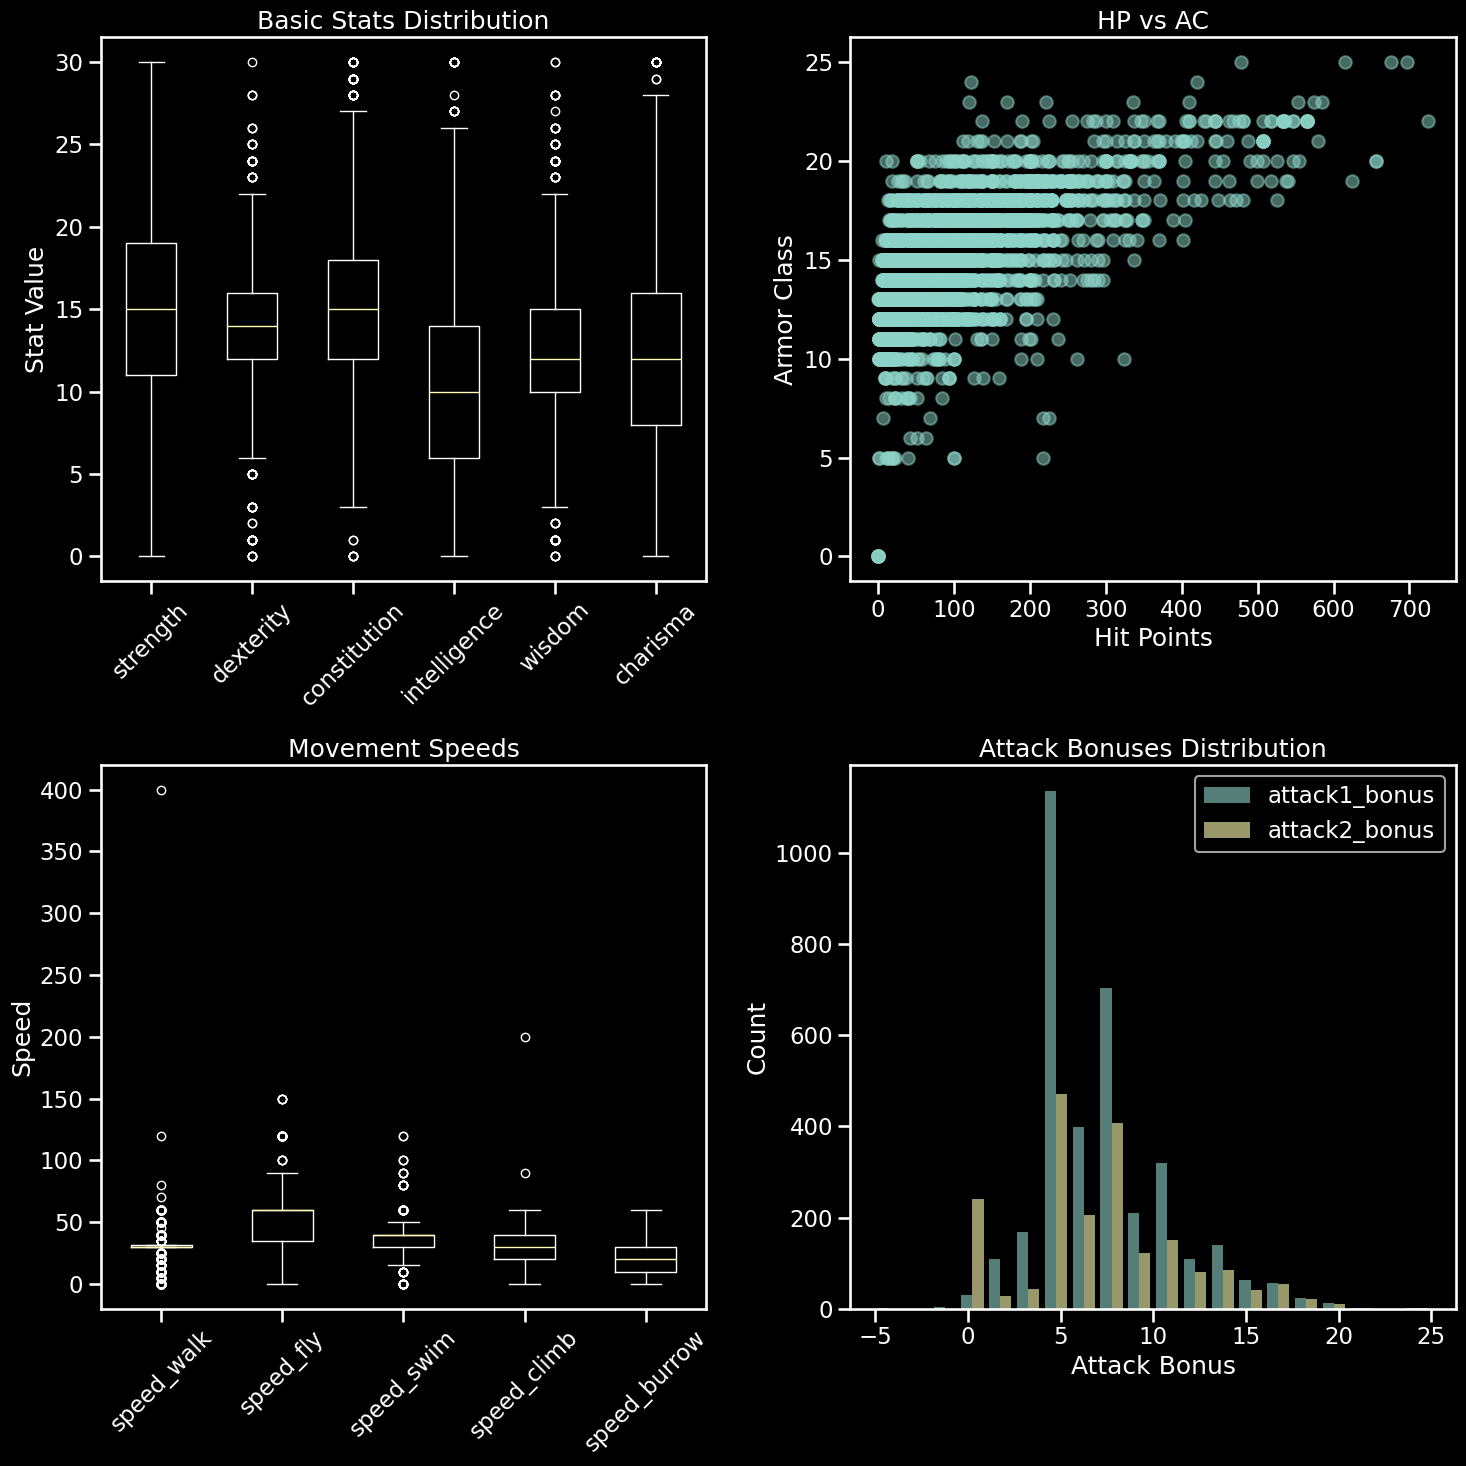

Total monsters: 3911
Monsters with both HP and AC: 3685
strength: 3697 non-null values
dexterity: 3685 non-null values
constitution: 3659 non-null values
intelligence: 3678 non-null values
wisdom: 3672 non-null values
charisma: 3669 non-null values


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plotting style

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# 1. Basic Stats Distribution (STR, DEX, CON, INT, WIS, CHA)
stats = ['strength', 'dexterity', 'constitution', 'intelligence', 'wisdom', 'charisma']
stats_data = [monster_df[stat].drop_nulls().to_numpy() for stat in stats]

axes[0,0].boxplot(stats_data, tick_labels=stats)
axes[0,0].set_title('Basic Stats Distribution')
axes[0,0].set_ylabel('Stat Value')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. HP vs AC Scatter Plot
# Filter to get only rows where both HP and AC are non-null
valid_monsters = monster_df.filter(
    (pl.col('hp').is_not_null()) & 
    (pl.col('ac').is_not_null())
)
hp_data = valid_monsters['hp'].to_numpy()
ac_data = valid_monsters['ac'].to_numpy()
axes[0,1].scatter(hp_data, ac_data, alpha=0.5)
axes[0,1].set_title('HP vs AC')
axes[0,1].set_xlabel('Hit Points')
axes[0,1].set_ylabel('Armor Class')

# 3. Movement Speeds
speed_cols = ['speed_walk', 'speed_fly', 'speed_swim', 'speed_climb', 'speed_burrow']
speed_data = [monster_df[speed].drop_nulls().to_numpy() for speed in speed_cols]

axes[1,0].boxplot(speed_data, tick_labels=speed_cols)
axes[1,0].set_title('Movement Speeds')
axes[1,0].set_ylabel('Speed')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Attack Bonuses
attack_cols = ['attack1_bonus', 'attack2_bonus']
attack_data = [monster_df[attack].drop_nulls().to_numpy() for attack in attack_cols]

axes[1,1].hist(attack_data, label=attack_cols, alpha=0.6, bins=20)
axes[1,1].set_title('Attack Bonuses Distribution')
axes[1,1].set_xlabel('Attack Bonus')
axes[1,1].set_ylabel('Count')
axes[1,1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print some statistics about the data
print(f"Total monsters: {len(monster_df)}")
print(f"Monsters with both HP and AC: {len(valid_monsters)}")
for stat in stats:
    non_null_count = len(monster_df[stat].drop_nulls())
    print(f"{stat}: {non_null_count} non-null values")